# Telangana Crop Health Challenge
---
###  Can you predict the health status of crops?




---



# Setup Notebook

In [1]:
%%capture
!pip install earthengine-api geopandas rasterio rasterstats shapely

In [2]:
pip install earthengine-api

  Using cached earthengine_api-1.4.5-py3-none-any.whl.metadata (1.8 kB)
  Using cached google_cloud_storage-2.19.0-py2.py3-none-any.whl.metadata (9.1 kB)
  Using cached google_api_python_client-2.159.0-py2.py3-none-any.whl.metadata (6.7 kB)
  Using cached google_auth-2.37.0-py2.py3-none-any.whl.metadata (4.8 kB)
  Using cached google_auth_httplib2-0.2.0-py2.py3-none-any.whl.metadata (2.2 kB)
  Using cached httplib2-0.22.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached google_api_core-2.24.0-py3-none-any.whl.metadata (3.0 kB)
  Using cached uritemplate-4.1.1-py2.py3-none-any.whl.metadata (2.9 kB)
  Using cached google_cloud_core-2.4.1-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached google_resumable_media-2.7.2-py2.py3-none-any.whl.metadata (2.2 kB)
  Using cached google_crc32c-1.6.0-cp310-cp310-win_amd64.whl.metadata (2.4 kB)
  Using cached proto_plus-1.25.0-py3-none-any.whl.metadata (2.2 kB)
Using cached earthengine_api-1.4.5-py3-none-any.whl (457 kB)
Using cached google_api_p

In [3]:
pip install geemap

  Using cached geemap-0.35.1-py2.py3-none-any.whl.metadata (12 kB)
  Using cached bqplot-0.12.44-py2.py3-none-any.whl.metadata (6.4 kB)
  Using cached colour-0.1.5-py2.py3-none-any.whl.metadata (18 kB)
  Using cached eerepr-0.1.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached folium-0.19.4-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached geocoder-1.38.1-py2.py3-none-any.whl.metadata (14 kB)
  Using cached ipyevents-2.0.2-py3-none-any.whl.metadata (2.9 kB)
  Using cached ipyfilechooser-0.6.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached ipyleaflet-0.19.2-py3-none-any.whl.metadata (5.3 kB)
  Using cached ipytree-0.2.2-py2.py3-none-any.whl.metadata (849 bytes)
  Using cached pyperclip-1.9.0-py3-none-any.whl
  Using cached pyshp-2.3.1-py2.py3-none-any.whl.metadata (55 kB)
  Using cached python_box-7.3.2-cp310-cp310-win_amd64.whl.metadata (8.3 kB)
  Using cached scooby-0.10.0-py3-none-any.whl.metadata (15 kB)
  Using cached ipywidgets-8.1.5-py3-none-any.whl.metadata (2.3 kB)
  U

In [1]:
pip install geopandas rasterio rasterstats shapely

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U scikit-image

  Using cached scikit_image-0.25.0-cp310-cp310-win_amd64.whl.metadata (14 kB)
  Using cached imageio-2.37.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
Using cached scikit_image-0.25.0-cp310-cp310-win_amd64.whl (12.8 MB)
Using cached imageio-2.37.0-py3-none-any.whl (315 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install dask[dataframe]

In [5]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install lightgbm

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ----------------------------- ---------- 1.0/1.4 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 6.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# Libraries and Modules Import

In [60]:
# Standard Library Imports
from concurrent.futures import ThreadPoolExecutor, as_completed
from joblib import Parallel, delayed
from tqdm import tqdm
from datetime import datetime
from pathlib import Path
import os
import random

# Third-Party Imports
import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from lightgbm import LGBMClassifier
from shapely.affinity import scale, translate
from skimage import exposure
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder

from shapely import wkt
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

import logging
# Set up a logger to capture Rasterio warnings
logging.getLogger("rasterio._env").setLevel(logging.ERROR)

# Project Setup and Earth Engine Initialization

In [61]:
# Define the root path for the project
root_path = Path(".")

In [3]:
# Authenticate with Google Earth Engine
# This opens a browser prompt for authentication, if not previously authenticated
ee.Authenticate()

# Initialize Earth Engine with a specific project
# Replace "project" with your project ID as needed
ee.Initialize(project="ee-souhalabidi14")

Enter verification code: 4/1AanRRrs-oX-yEb2QWuSyl_WVIdW70UDmtJ7dBn2d7_QhXMeBix0Zlrmc6Tc

Successfully saved authorization token.


# Data Loading and Preprocessing

**Load Train and Test**

In [62]:
# Load training and testing datasets from CSV files
train = pd.read_csv(root_path / 'Train.csv')
test = pd.read_csv(root_path / 'Test.csv')

**Convert Geometry Columns to Geospatial Format**

In [63]:
# Convert WKT geometry to actual geometry objects in both datasets
train['geometry'] = train['geometry'].apply(wkt.loads)
test['geometry'] = test['geometry'].apply(wkt.loads)

**Convert DataFrames to GeoDataFrames**

In [64]:
# Convert pandas DataFrames to GeoDataFrames with CRS set to 'epsg:4326'
train = gpd.GeoDataFrame(train, crs='epsg:4326')
test = gpd.GeoDataFrame(test, crs='epsg:4326')

**Concatenate Train and Test Data for Unified Processing**

In [65]:
# Concatenate train and test datasets into a single DataFrame for consistent processing
# 'dataset' column distinguishes between train and test rows
data = pd.concat(
    [train.assign(dataset='train'), test.assign(dataset='test')]
).reset_index(drop=True)


**Scale Geometry Objects**

In [66]:
# Function to scale each geometry around its centroid
def scale_geometry(geometry, scale_factor):
    """
    Scale a geometry object around its centroid.

    Parameters:
        geometry (shapely.geometry.base.BaseGeometry): Geometry to scale.
        scale_factor (float): Factor by which to scale the geometry.

    Returns:
        shapely.geometry.base.BaseGeometry: Scaled geometry object.
    """
    # Calculate centroid
    centroid = geometry.centroid
    # Translate geometry to origin
    translated_geometry = translate(geometry, -centroid.x, -centroid.y)
    # Scale geometry
    scaled_geometry = scale(translated_geometry, xfact=scale_factor, yfact=scale_factor, origin=(0, 0))
    # Translate back to the original centroid
    return translate(scaled_geometry, centroid.x, centroid.y)

In [67]:
# Set the scaling factor
scale_factor = 5

# Apply the scaling function to each geometry in the data
# This modifies each geometry in place by the defined scale factor
data['geometry'] = data['geometry'].apply(scale_geometry, scale_factor=scale_factor)

# Download Image Data

**Utils**

In [68]:
# Function to ensure date format is correct
def format_date(date_str):
    """Convert date string to 'YYYY-MM-DD' format."""
    try:
        return datetime.strptime(date_str, '%d-%m-%Y').strftime('%Y-%m-%d')
    except ValueError:
        print(f"Error: Invalid date format for {date_str}. Expected 'DD-MM-YYYY'.")
        return None

**Convert GeoDataFrame to Earth Engine FeatureCollection**

In [69]:
# Function to convert a GeoDataFrame to Google Earth Engine FeatureCollection
def gdf_to_gee(gdf):
    """Converts a GeoDataFrame to an Earth Engine FeatureCollection."""
    features = []
    for _, row in gdf.iterrows():
        geom = row['geometry'].__geo_interface__  # Convert geometry to GeoJSON format
        feature = ee.Feature(ee.Geometry(geom), row.to_dict())  # Create an EE Feature
        features.append(feature)
    return ee.FeatureCollection(features)

# Convert the entire dataset GeoDataFrame to a FeatureCollection for GEE
gee_feature_collection = gdf_to_gee(data)

**Initialize Earth Engine and Set Up Directories**

In [70]:
# if you already downloaded the data.
donwload = False

# Initialize Earth Engine
ee.Initialize()

# Remove existing 'downloads' folder if it exists
if os.path.exists('downloads'):
    os.system('rm -rf downloads')

# Ensure the output directory exists
output_folder = 'downloads'
os.makedirs(output_folder, exist_ok=True)

**Download from Earth Engine**

In [71]:
# Function to download RGB images from Earth Engine
def download_rgb_image(collection_name, bands, start_date, end_date, region, output_folder='downloads'):
    """Download RGB bands from a GEE collection filtered by date and region."""
    # Load the image collection, filter by date, and clip to region
    collection = ee.ImageCollection(collection_name).filterDate(start_date, end_date).filterBounds(region)
    image = collection.sort('system:time_start', False).first().select(bands).clip(region)  # Most recent image

    # Define unique filename based on image dates
    image_id = image.id().getInfo() or f'image_{start_date}_{end_date}'
    image_name = f'{output_folder}/{image_id}_RGB_{start_date}_{end_date}.tif'

    # Export the image to a GeoTIFF file
    geemap.ee_export_image(
        image,
        filename=image_name,
        scale=10,  # Sentinel-2 resolution in meters
        region=region,
        file_per_band=False,  # Save as a multi-band TIFF
        crs='EPSG:4326'
    )
    print(f"Downloaded: {image_name}")
    return image_name

In [72]:
# Function to process each row in the dataset for image download
def process_row(index, row):
    # Format start and end dates
    start_date = format_date(row['SDate'])
    end_date = format_date(row['HDate'])

    # Skip rows with invalid dates
    if not start_date or not end_date:
        print(f"Skipping entry due to invalid dates: SDate={row['SDate']}, HDate={row['HDate']}")
        return index, None

    # Extract and check geometry
    region_geometry = row['geometry']
    district = row['District']

    # Verify valid geometry and convert it to EE format
    if region_geometry.is_empty:
        print(f"Skipping entry due to empty geometry for District: {district}")
        return index, None

    # Convert geometry type to EE compatible format
    if region_geometry.geom_type == 'Polygon':
        region = ee.Geometry.Polygon(region_geometry.__geo_interface__['coordinates'])
    elif region_geometry.geom_type == 'MultiPolygon':
        coords = [polygon.exterior.coords[:] for polygon in region_geometry.geoms]
        region = ee.Geometry.MultiPolygon(coords)
    else:
        print(f"Skipping unsupported geometry type: {region_geometry.geom_type} for District: {district}")
        return index, None

    # Define Sentinel-2 collection and bands
    image_collection_name = 'COPERNICUS/S2'
    bands = ['B4', 'B3', 'B2', 'B8', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12']

    # Attempt to download the image
    try:
        image_file = download_rgb_image(image_collection_name, bands, start_date, end_date, region, output_folder)
        return index, image_file
    except Exception as e:
        print(f"Error processing entry for District {district}: {e}")
        return index, None

In [111]:
if donwload:
  # Execute image downloads for each row in parallel to improve performance
  with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust the number of workers as needed
      futures = [executor.submit(process_row, index, row) for index, row in data.iterrows()]
      for future in as_completed(futures):
          index, image_file = future.result()
          if image_file:
              data.at[index, 'tif_path'] = image_file  # Store the downloaded file path
else:
  # Load existing data with image paths if downloads are not required
  os.system('cp -r /EarthEngineImages/downloads .')
  data_path = "./EarthEngineImages/datajuan.csv"

  data = pd.read_csv(data_path, sep =',')

In [112]:
data.head()

,FarmID,category,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,...,CTransp,IrriType,IrriSource,IrriCount,WaterCov,ExpYield,Season,geometry,dataset,tif_path
0,1326576,Healthy,Paddy,Telangana,Medak,Kulcharam,25-11-2023,14-04-2024,97,54,...,Transplanting,Flood,Groundwater,4,87,17,Rabi,POLYGON ((78.18079255482755 17.978971746424413...,train,./EarthEngineImages/downloads/20240412T050649_...
1,1326577,Healthy,Paddy,Telangana,Medak,Kulcharam,13-11-2023,26-04-2024,82,58,...,Transplanting,Flood,Canal,5,94,15,Rabi,POLYGON ((78.17483419891283 17.981508840879556...,train,./EarthEngineImages/downloads/20240425T051649_...
2,1326578,Healthy,Paddy,Telangana,Medak,Kulcharam,19-12-2023,28-04-2024,92,91,...,Transplanting,Flood,Canal,3,99,20,Rabi,POLYGON ((78.16888476438905 17.976727511659835...,train,./EarthEngineImages/downloads/20240427T050651_...
3,1331836,Diseased,Paddy,Telangana,Medak,Kulcharam,11-02-2023,04-11-2024,91,52,...,Transplanting,Flood,Canal,5,92,16,Rabi,POLYGON ((78.16821795882959 17.974690113471414...,train,./EarthEngineImages/downloads/20241103T050951_...
4,1326579,Diseased,Paddy,Telangana,Medak,Kulcharam,12-12-2023,19-05-2024,94,55,...,Transplanting,Flood,Canal,5,97,20,Rabi,POLYGON ((78.17244459940454 17.969620948965225...,train,./EarthEngineImages/downloads/20240517T050651_...


# Visualization

In [113]:
# Function to scale pixel values to the 0–255 range for better visualization
def scale_band(band):
    """
    Scales pixel values of a single band to the 0-255 range.

    Parameters:
    - band: np.array, pixel values of the band

    Returns:
    - np.array, scaled pixel values in the 0-255 range
    """
    band = band.astype(np.float32)  # Ensure values are in float for scaling
    return 255 * (band - np.min(band)) / (np.max(band) - np.min(band))  # Scale to 0–255

# Function to visualize RGB image with scaling, contrast adjustments, and optional gamma correction
def visualize_rgb_image(file_path, gamma=0.6, contrast_stretch=True):
    """
    Visualize an RGB image using matplotlib with scaling, optional gamma correction, and contrast stretching.

    Parameters:
    - file_path: str, path to the RGB image file (GeoTIFF)
    - gamma: float, gamma correction factor (default=0.6)
    - contrast_stretch: bool, whether to apply contrast stretching (default=True)
    """
    # Open the image file
    with rasterio.open(file_path) as src:
        # Read RGB bands (assuming Sentinel-2 band order: Red=B4, Green=B3, Blue=B2)
        red = src.read(3)  # Band 4 for Red
        green = src.read(2)  # Band 3 for Green
        blue = src.read(1)  # Band 2 for Blue

        # Scale each band to the 0–255 range for better visualization
        red_scaled = scale_band(red)
        green_scaled = scale_band(green)
        blue_scaled = scale_band(blue)

        # Stack the scaled RGB bands into a single image
        rgb = np.dstack((red_scaled, green_scaled, blue_scaled)).astype(np.uint8)

        # Apply contrast stretching if specified
        if contrast_stretch:
            p2, p98 = np.percentile(rgb, (2, 98))  # Calculate 2nd and 98th percentiles for stretching
            rgb = exposure.rescale_intensity(rgb, in_range=(p2, p98))

        # Apply gamma correction to adjust brightness
        rgb = exposure.adjust_gamma(rgb, gamma=gamma)

        # Display the processed image using matplotlib
        plt.figure(figsize=(5, 5))
        plt.imshow(rgb)
        plt.axis('off')  # Hide axes for a cleaner look
        plt.title("RGB Composite (Red-Green-Blue) with Scaling, Contrast Stretch, and Gamma Correction")
        plt.show()

    return rgb

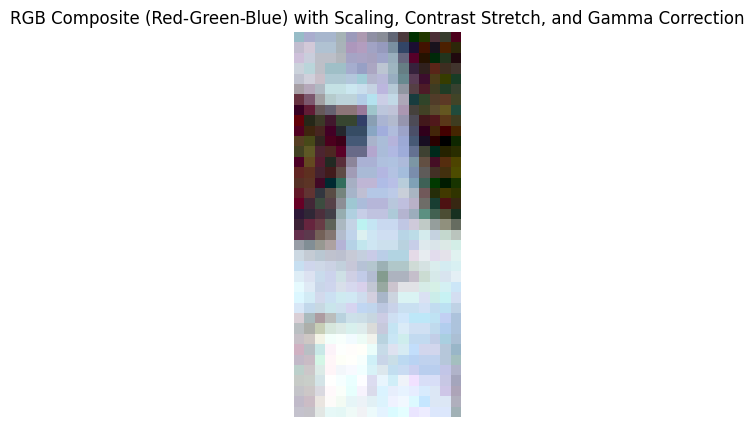

In [114]:
import os

# ... (rest of your code)

# Select a random image file from the dataset and visualize it
# Get a list of existing tif files in the downloads directory
tif_files = [f for f in os.listdir('./EarthEngineImages/downloads') if f.endswith('.tif')]

# Check if any tif files exist
if tif_files:
    # Select a random tif file path from the existing files
    path = os.path.join('./EarthEngineImages/downloads', random.choice(tif_files))
    image = visualize_rgb_image(path)
else:
    print("No .tif files found in the downloads directory. Please check your data.")

In [89]:
# Select a random image file from the dataset and visualize it


# path = random.choice(data['tif_path'].values)
# image = visualize_rgb_image(path)

# Feature Engineering

**Utils**

In [115]:
# Example feature calculation functions
def calculate_ndvi(nir_band, red_band):
    """Calculate NDVI (Normalized Difference Vegetation Index)."""
    ndvi = (nir_band - red_band) / (nir_band + red_band)
    return np.nanmean(ndvi)

def calculate_evi(nir_band, red_band, blue_band):
    """Calculate EVI (Enhanced Vegetation Index)."""
    evi = 2.5 * (nir_band - red_band) / (nir_band + 6 * red_band - 7.5 * blue_band + 1)
    return np.nanmean(evi)

def calculate_ndwi(nir_band, green_band):
    """Calculate NDWI (Normalized Difference Water Index)."""
    ndwi = (green_band - nir_band) / (green_band + nir_band)
    return np.nanmean(ndwi)

def calculate_gndvi(nir_band, green_band):
    """Calculate GNDVI (Green Normalized Difference Vegetation Index)."""
    gndvi = (nir_band - green_band) / (nir_band + green_band)
    return np.nanmean(gndvi)

def calculate_savi(nir_band, red_band, L=0.5):
    """Calculate SAVI (Soil Adjusted Vegetation Index)."""
    savi = ((nir_band - red_band) / (nir_band + red_band + L)) * (1 + L)
    return np.nanmean(savi)

def calculate_msavi(nir_band, red_band):
    """Calculate MSAVI (Modified Soil Adjusted Vegetation Index)."""
    msavi = (2 * nir_band + 1 - np.sqrt((2 * nir_band + 1)**2 - 8 * (nir_band - red_band))) / 2
    return np.nanmean(msavi)

In [116]:
# Function to calculate features for each row in the data


def process_row_for_features(index, row):
    features = {'index': index}

    # Retrieve the TIFF file path and check if it's valid
    tif_path = row['tif_path']
    if not isinstance(tif_path, str):
        print(f"Skipping entry due to missing tif_path for index {index}")
        # Add NaN for all features if path is missing
        features.update({
            'ndvi': np.nan,
            'evi': np.nan,
            'ndwi': np.nan,
            'gndvi': np.nan,
            'savi': np.nan,
            'msavi': np.nan
        })
        return features

    # Open the TIFF file and read bands for feature calculation
    with rasterio.open(tif_path) as src:
        red = src.read(3)    # B4 for Red
        green = src.read(2)  # B3 for Green
        blue = src.read(1)   # B2 for Blue
        nir = src.read(4)    # B8 for NIR

        # Calculate each feature
        features['ndvi'] = calculate_ndvi(nir, red)
        features['evi'] = calculate_evi(nir, red, blue)
        features['ndwi'] = calculate_ndwi(nir, green)
        features['gndvi'] = calculate_gndvi(nir, green)
        features['savi'] = calculate_savi(nir, red)
        features['msavi'] = calculate_msavi(nir, red)

    return features

In [44]:
# # Function to calculate features for each row in the data
# def process_row_for_features(index, row):
#     features = {'index': index}

#     # Retrieve the TIFF file path and check if it's valid
#     tif_path = row['tif_path']
#     if not isinstance(tif_path, str):
#         print(f"Skipping entry due to missing tif_path for index {index}")
#         # Add NaN for all features if path is missing
#         features.update({
#             'ndvi': np.nan,
#             'evi': np.nan,
#             'ndwi': np.nan,
#             'gndvi': np.nan,
#             'savi': np.nan,
#             'msavi': np.nan
#         })
#         return features

#     # Check if the file exists before attempting to open it
#     if not os.path.exists(tif_path):
#         print(f"File not found: {tif_path}")
#         # Add NaN for all features if file is missing
#         features.update({
#             'ndvi': np.nan,
#             'evi': np.nan,
#             'ndwi': np.nan,
#             'gndvi': np.nan,
#             'savi': np.nan,
#             'msavi': np.nan
#         })
#         return features

#     # Open the TIFF file and read bands for feature calculation
#     try:
#         with rasterio.open(tif_path) as src:
#             red = src.read(3)    # B4 for Red
#             green = src.read(2)  # B3 for Green
#             blue = src.read(1)   # B2 for Blue
#             nir = src.read(4)    # B8 for NIR

#             # Calculate each feature
#             features['ndvi'] = calculate_ndvi(nir, red)
#             features['evi'] = calculate_evi(nir, red, blue)
#             features['ndwi'] = calculate_ndwi(nir, green)
#             features['gndvi'] = calculate_gndvi(nir, green)
#             features['savi'] = calculate_savi(nir, red)
#             features['msavi'] = calculate_msavi(nir, red)
#     except rasterio.errors.RasterioIOError as e:
#         print(f"Error opening raster file {tif_path}: {e}")
#         # Add NaN for all features if there's an error opening the file
#         features.update({
#             'ndvi': np.nan,
#             'evi': np.nan,
#             'ndwi': np.nan,
#             'gndvi': np.nan,
#             'savi': np.nan,
#             'msavi': np.nan
#         })

#     return features

**Calculate Features**

In [117]:
# Use parallel processing to calculate features for each row
# `tqdm` provides a progress bar to track completion
new_features = Parallel(n_jobs=-1)(delayed(process_row_for_features)(index, row)
                                   for index, row in tqdm(data.iterrows(), total=len(data)))







  0%|                                                                                        | 0/11791 [00:00<?, ?it/s]





  0%|▏                                                                              | 24/11791 [00:01<11:10, 17.55it/s]





  0%|▏                                                                              | 36/11791 [00:01<07:33, 25.89it/s]





  0%|▎                                                                              | 48/11791 [00:01<05:50, 33.55it/s]





  1%|▍                                                                              | 60/11791 [00:01<04:22, 44.71it/s]





  1%|▍                                                                              | 72/11791 [00:01<03:28, 56.20it/s]





  1%|▌                                                                              | 84/11791 [00:02<02:53, 67.43it/s]





  1%|▊                                                                            | 116/11791 [00:02<01:38, 119.01it/s]

 21%|████████████████                                                            | 2496/11791 [00:17<01:00, 153.20it/s]





 22%|████████████████▍                                                           | 2544/11791 [00:17<01:00, 153.69it/s]





 22%|████████████████▋                                                           | 2592/11791 [00:17<01:00, 151.36it/s]





 22%|█████████████████                                                           | 2640/11791 [00:18<00:59, 154.09it/s]





 23%|█████████████████▎                                                          | 2688/11791 [00:18<00:58, 156.89it/s]





 23%|█████████████████▋                                                          | 2736/11791 [00:18<00:58, 155.36it/s]





 24%|█████████████████▉                                                          | 2784/11791 [00:19<00:57, 156.87it/s]





 24%|██████████████████▎                                                         | 2832/11791 [00:19<00:56, 158.11it/s]







 44%|█████████████████████████████████▋                                          | 5232/11791 [00:33<00:37, 176.08it/s]





 45%|██████████████████████████████████                                          | 5280/11791 [00:33<00:38, 170.02it/s]





 45%|██████████████████████████████████▎                                         | 5328/11791 [00:33<00:36, 179.22it/s]





 46%|██████████████████████████████████▋                                         | 5376/11791 [00:33<00:37, 171.69it/s]





 46%|██████████████████████████████████▉                                         | 5424/11791 [00:34<00:39, 161.72it/s]





 46%|███████████████████████████████████▎                                        | 5472/11791 [00:34<00:40, 155.90it/s]





 47%|███████████████████████████████████▌                                        | 5520/11791 [00:34<00:40, 156.19it/s]





 47%|███████████████████████████████████▉                                        | 5568/11791 [00:35<00:39, 156.09it/s]







 68%|███████████████████████████████████████████████████▎                        | 7968/11791 [00:49<00:21, 176.89it/s]





 68%|███████████████████████████████████████████████████▋                        | 8016/11791 [00:49<00:21, 179.54it/s]





 68%|███████████████████████████████████████████████████▉                        | 8064/11791 [00:50<00:23, 160.83it/s]





 69%|████████████████████████████████████████████████████▎                       | 8112/11791 [00:50<00:22, 160.10it/s]





 69%|████████████████████████████████████████████████████▌                       | 8160/11791 [00:50<00:21, 167.09it/s]





 70%|████████████████████████████████████████████████████▉                       | 8208/11791 [00:51<00:20, 171.98it/s]





 70%|█████████████████████████████████████████████████████▏                      | 8256/11791 [00:51<00:20, 171.10it/s]





 70%|█████████████████████████████████████████████████████▌                      | 8304/11791 [00:51<00:19, 179.45it/s]







 91%|████████████████████████████████████████████████████████████████████       | 10704/11791 [01:06<00:07, 153.71it/s]





 91%|████████████████████████████████████████████████████████████████████▍      | 10752/11791 [01:06<00:06, 158.63it/s]





 92%|████████████████████████████████████████████████████████████████████▋      | 10800/11791 [01:06<00:05, 178.76it/s]





 92%|█████████████████████████████████████████████████████████████████████      | 10848/11791 [01:07<00:05, 180.28it/s]





 92%|█████████████████████████████████████████████████████████████████████▎     | 10896/11791 [01:07<00:04, 202.72it/s]





 93%|█████████████████████████████████████████████████████████████████████▌     | 10944/11791 [01:07<00:04, 196.30it/s]





 93%|█████████████████████████████████████████████████████████████████████▉     | 10992/11791 [01:07<00:04, 180.04it/s]





 94%|██████████████████████████████████████████████████████████████████████▏    | 11040/11791 [01:08<00:04, 178.96it/s]







**Merge New Features with Original Data**

In [118]:
# Convert list of features to a DataFrame and merge with the original data
new_features_df = pd.DataFrame(new_features).set_index('index')
data = data.join(new_features_df)

In [119]:
data.head()

,FarmID,category,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,...,Season,geometry,dataset,tif_path,ndvi,evi,ndwi,gndvi,savi,msavi
0,1326576,Healthy,Paddy,Telangana,Medak,Kulcharam,25-11-2023,14-04-2024,97,54,...,Rabi,POLYGON ((78.18079255482755 17.978971746424413...,train,./EarthEngineImages/downloads/20240412T050649_...,0.100756,-0.793684,8.488031,0.127153,0.151125,4232.596191
1,1326577,Healthy,Paddy,Telangana,Medak,Kulcharam,13-11-2023,26-04-2024,82,58,...,Rabi,POLYGON ((78.17483419891283 17.981508840879556...,train,./EarthEngineImages/downloads/20240425T051649_...,0.188090,0.564248,11.493762,0.187815,0.282110,3249.392822
2,1326578,Healthy,Paddy,Telangana,Medak,Kulcharam,19-12-2023,28-04-2024,92,91,...,Rabi,POLYGON ((78.16888476438905 17.976727511659835...,train,./EarthEngineImages/downloads/20240427T050651_...,0.206596,-1.456745,10.166884,0.206553,0.309869,3741.956055
3,1331836,Diseased,Paddy,Telangana,Medak,Kulcharam,11-02-2023,04-11-2024,91,52,...,Rabi,POLYGON ((78.16821795882959 17.974690113471414...,train,./EarthEngineImages/downloads/20241103T050951_...,0.206250,2.206184,10.446196,0.220995,0.309350,3673.396729
4,1326579,Diseased,Paddy,Telangana,Medak,Kulcharam,12-12-2023,19-05-2024,94,55,...,Rabi,POLYGON ((78.17244459940454 17.969620948965225...,train,./EarthEngineImages/downloads/20240517T050651_...,0.179721,-0.743638,8.665929,0.160657,0.269563,4227.338379


**Split Dataset into Train and Test**

In [120]:
# Split the data into train and test sets based on the 'dataset' column
train = data[data.dataset == 'train'].reset_index(drop=True)
test = data[data.dataset == 'test'].reset_index(drop=True)

In [121]:
# Define columns to drop before encoding and training
to_drop = [
    'geometry', 'tif_path',  # Spatial and file path information
    'dataset', 'FarmID',     # Columns that are not needed for modeling
]

# Drop the specified columns from train and test sets
train.drop(columns=to_drop, inplace=True)
test.drop(columns=to_drop, inplace=True)


In [122]:
# Concatenate train and test datasets for uniform encoding of categorical columns
data_combined = pd.concat([train, test], ignore_index=True)

In [123]:
# Create a mapping for the target variable 'category' to numeric labels, excluding NaN values
category_mapper = {label: idx for idx, label in enumerate(data_combined['category'].unique()) if pd.notna(label)}
idx_to_category_mapper = {idx: label for idx, label in enumerate(data_combined['category'].unique()) if pd.notna(label)}

# Map the 'category' column to the new 'target' column using the mapping, handling NaN values as needed
data_combined['target'] = data_combined['category'].map(category_mapper)

# Drop the original 'category' column now that we have the 'target' column
data_combined.drop(columns=['category'], inplace=True)

In [124]:
# Identify categorical columns to encode
categorical_cols = data_combined.select_dtypes(include=['object']).columns

# Apply Label Encoding for all categorical columns
for col in categorical_cols:
    encoder = LabelEncoder()
    data_combined[col] = encoder.fit_transform(data_combined[col])

In [125]:
# Split the combined encoded data back into train and test
train_encoded = data_combined[data_combined.index < len(train)].reset_index(drop=True)
test_encoded = data_combined[data_combined.index >= len(train)].reset_index(drop=True)

# Model Training

In [126]:
# Separate features and target variable in the train set
X = train_encoded.drop(columns=['target'])
y = train_encoded['target'].astype(int)

In [127]:
# Stratified split based on 'target' for training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [128]:
# Configuration dictionary for LightGBM parameters
config_dict = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': len(category_mapper),  # Number of classes in the target
    'num_leaves': 81,
    'learning_rate': 0.01,
    'n_estimators': 500,
    'random_state': 42,
    'force_row_wise': 'true'
}

# Initialize LightGBM classifier with config_dict parameters
model = LGBMClassifier(**config_dict)

# Fit the model with an evaluation set for early stopping and progress tracking
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
)

[LightGBM] [Info] Total Bins 2562
[LightGBM] [Info] Number of data points in the train set: 7020, number of used features: 22
[LightGBM] [Info] Start training from score -0.195918
[LightGBM] [Info] Start training from score -2.792733
[LightGBM] [Info] Start training from score -2.795062
[LightGBM] [Info] Start training from score -2.890372


LGBMClassifier(force_row_wise='true', learning_rate=0.01,
               metric='multi_logloss', n_estimators=500, num_class=4,
               num_leaves=81, objective='multiclass', random_state=42)

In [129]:
# Predict on the validation set
y_pred = model.predict(X_valid)

# Generate classification report and weighted F1 score
classification_rep = classification_report(y_valid, y_pred, target_names=list(category_mapper.keys()))
f1 = f1_score(y_valid, y_pred, average='weighted')

# Print model evaluation metrics
print("Classification Report:\n", classification_rep)
print("\nWeighted F1 Score:", f1)

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.82      1.00      0.90      1443
    Diseased       0.50      0.01      0.02       107
       Pests       0.00      0.00      0.00       107
    Stressed       0.00      0.00      0.00        98

    accuracy                           0.82      1755
   macro avg       0.33      0.25      0.23      1755
weighted avg       0.71      0.82      0.74      1755


Weighted F1 Score: 0.743073912831982


 # Submit

In [ ]:
# Load submission file
sample_submission = pd.read_csv(root_path / "SampleSubmission.csv")

# Predict on the test set
test_predictions = model.predict(test_encoded.drop(columns=['target']))  # Drop 'FarmID' if it exists in test_encoded

# Fill sample_submission.csv & Save
sample_submission['Target'] = test_predictions
sample_submission['Target'] = sample_submission['Target'].astype(int).map(idx_to_category_mapper)
sample_submission.to_csv('submission.csv', index=False)

In [ ]:
sample_submission.head()

,ID,Target
0,85197,Healthy
1,779677,Healthy
2,1331840,Healthy
3,483053,Healthy
4,542945,Healthy
